In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Import Data

In [2]:
img_load = ImageDataGenerator(rescale = 1.0/255)

X_train = img_load.flow_from_directory('/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/train/',
                                        target_size=(512,512),
                                        batch_size=32,
                                        color_mode='rgb',
                                        class_mode='binary')

X_test = img_load.flow_from_directory('/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/test/',
                                        target_size=(512,512),
                                        batch_size=10,
                                        color_mode='rgb',
                                        class_mode='binary')

Found 148 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


# Create CNN

In [3]:
model = Sequential([
    Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', input_shape = (512, 512, 3)),
    MaxPooling2D(pool_size = (2,2)),
    Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'),
    MaxPooling2D(pool_size = (2,2)),
    Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'),
    MaxPooling2D(pool_size = (2,2)),
    Flatten(),
    Dropout(0.25),
#     Dense(64, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 510, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 255, 255, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 126, 126, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 64)      36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 62, 62, 64)       0

In [5]:
callback_stop = EarlyStopping(
    monitor='accuracy',
    patience=5)

callback_lr_reduce = ReduceLROnPlateau(
    monitor='val_acc',
    patience= 2,
    verbose=1,
    factor=0.25,
    min_lr=0.00001)

callbacks = [callback_stop, callback_lr_reduce]

In [6]:
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy'])

# Training Model

In [7]:
output = model.fit(X_train, 
                   epochs = 10, 
                   validation_data = X_test, 
                   callbacks = callbacks)

Epoch 1/10
5/5 [==============================] - 17s 2s/step - loss: 0.9821 - accuracy: 0.5068 - val_loss: 0.9374 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/10
5/5 [==============================] - 8s 2s/step - loss: 0.6948 - accuracy: 0.6014 - val_loss: 0.5159 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 3/10
5/5 [==============================] - 5s 1s/step - loss: 0.5193 - accuracy: 0.8716 - val_loss: 0.3002 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 4/10
5/5 [==============================] - 6s 1s/step - loss: 0.3190 - accuracy: 0.9257 - val_loss: 0.2317 - val_accuracy: 0.9250 - lr: 0.0010
Epoch 5/10
5/5 [==============================] - 6s 1s/step - loss: 0.2151 - accuracy: 0.8851 - val_loss: 0.0628 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 6/10
5/5 [==============================] - 5s 1s/step - loss: 0.1459 - accuracy: 0.9459 - val_loss: 0.0222 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/10
5/5 [==============================] - 5s 1s/step - loss: 0.2493 - accuracy: 0.9054 - va

In [8]:
model.evaluate(X_test)

4/4 [==============================] - 1s 188ms/step - loss: 0.0086 - accuracy: 1.0000


[0.008626624010503292, 1.0]

# Result and Visualization

In [9]:
result = pd.DataFrame(output.history)
result

,loss,accuracy,val_loss,val_accuracy,lr
0,0.982069,0.506757,0.937370,0.500,0.001
1,0.694791,0.601351,0.515889,0.975,0.001
2,0.519257,0.871622,0.300211,0.975,0.001
3,0.318980,0.925676,0.231735,0.925,0.001
4,0.215124,0.885135,0.062840,0.975,0.001
5,0.145930,0.945946,0.022193,1.000,0.001
6,0.249333,0.905405,0.011757,1.000,0.001
7,0.166632,0.945946,0.020292,1.000,0.001
8,0.102303,0.952703,0.015125,1.000,0.001
9,0.046684,0.986486,0.008627,1.000,0.001


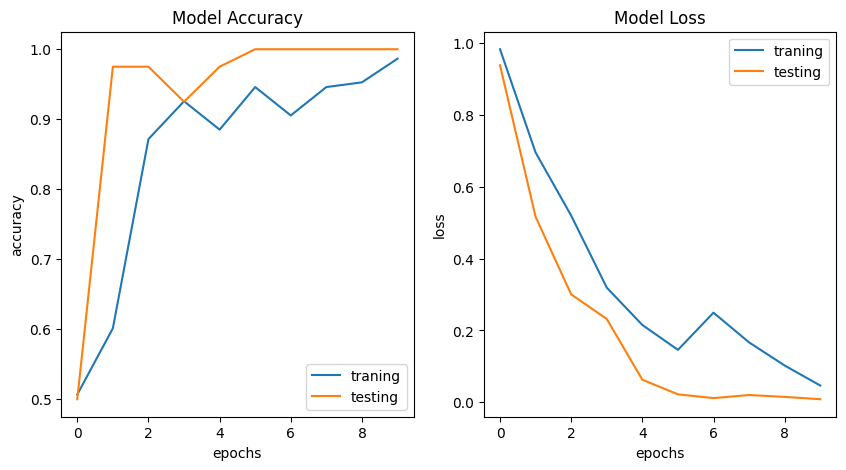

In [10]:
plt.figure(figsize = (10,5))

plt.subplot(1,2,1)
plt.plot(result['accuracy'], label = 'traning')
plt.plot(result['val_accuracy'], label = 'testing')
plt.title('Model Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(result['loss'], label = 'traning')
plt.plot(result['val_loss'], label = 'testing')
plt.title('Model Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [11]:
X_test.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [12]:
X_test.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

### Show result of model prediction
##### green title is correct
##### red title is incorrect

1/1 [==============================] - 0s 51ms/step


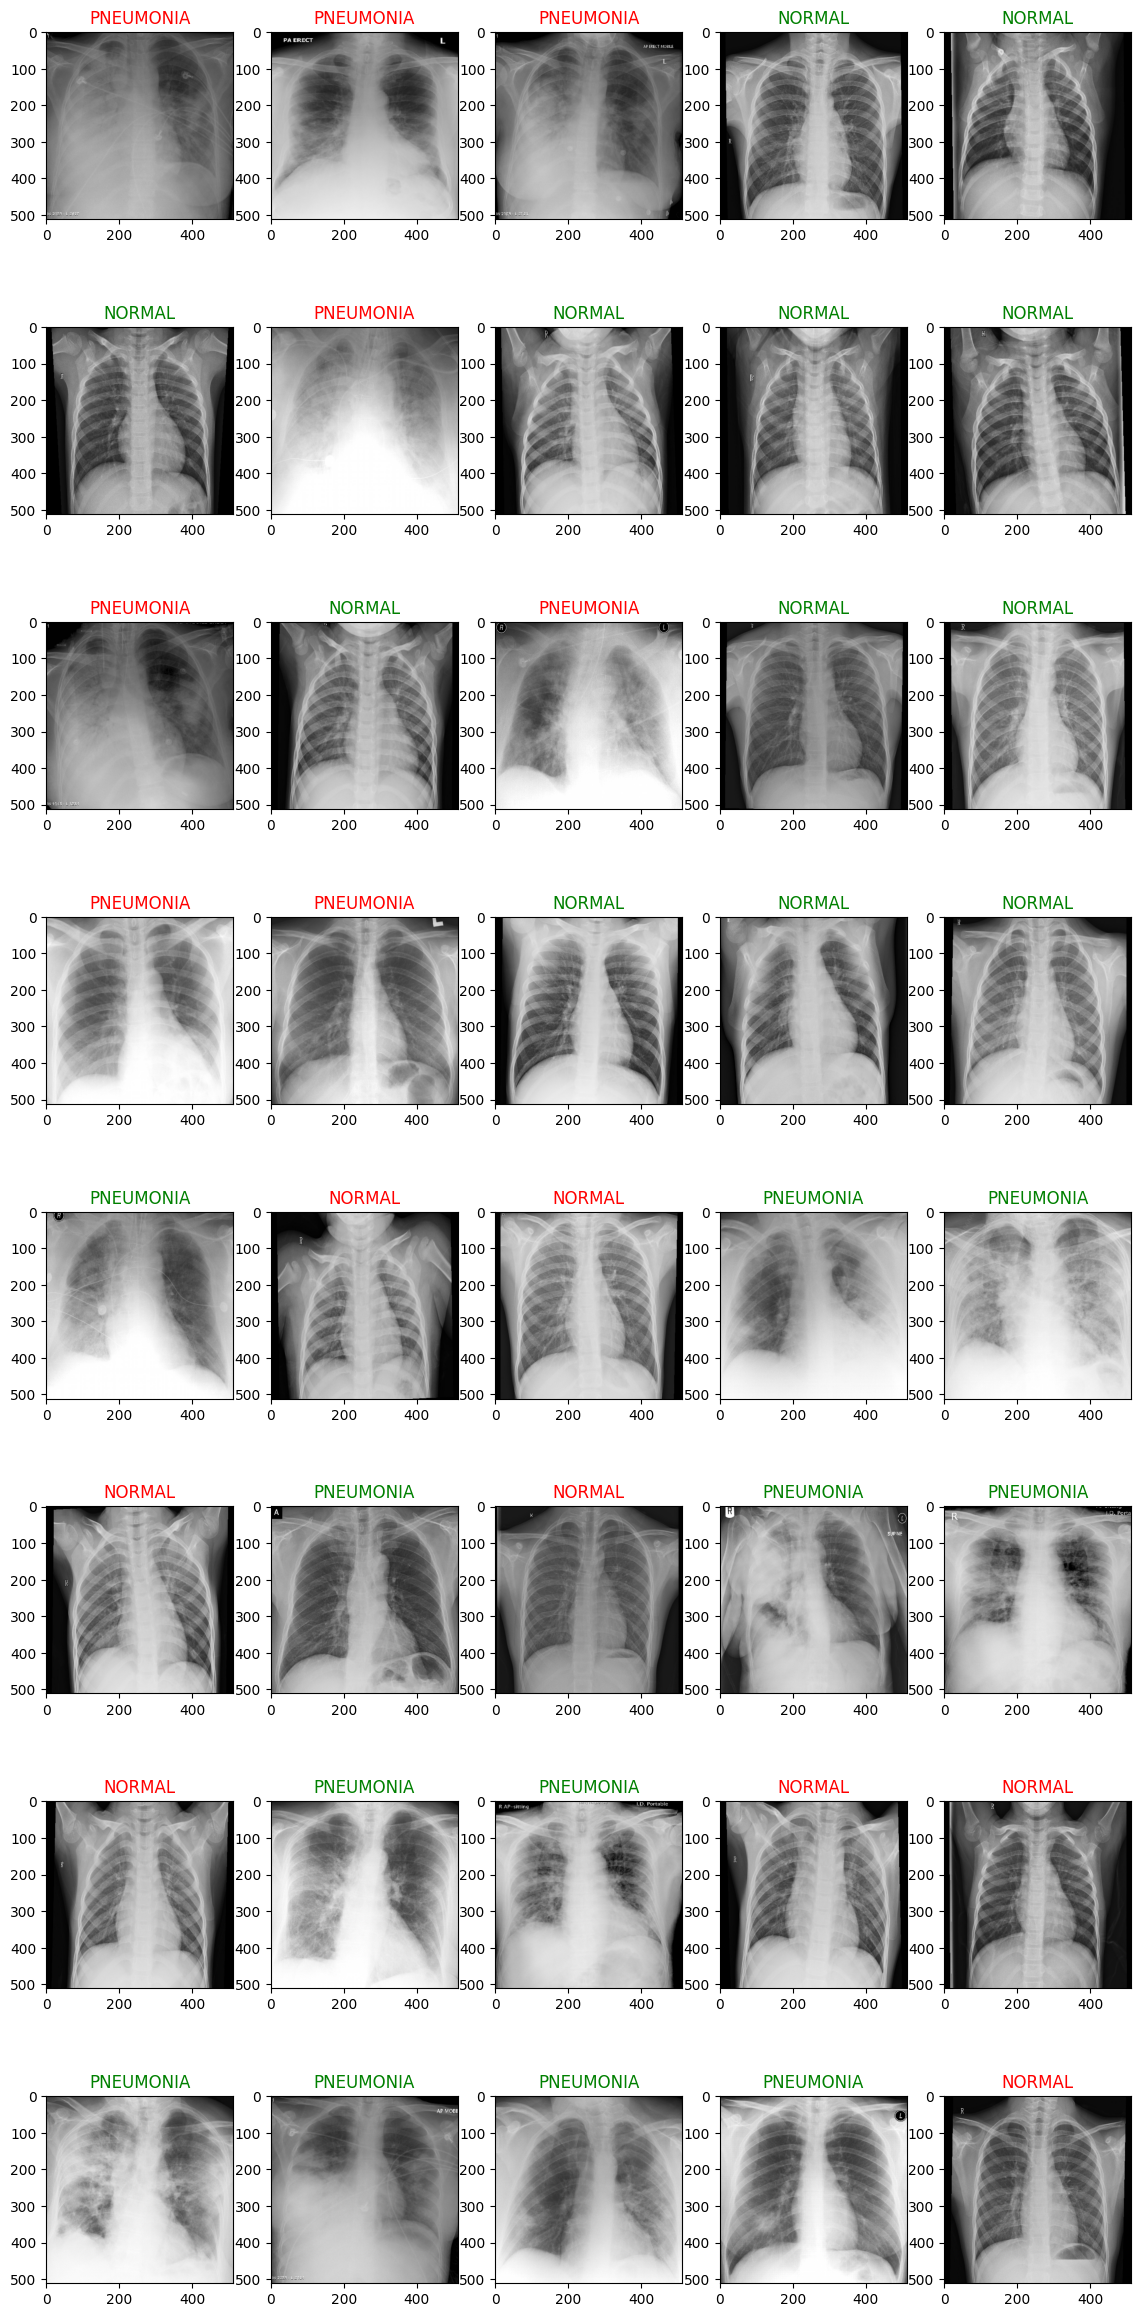

In [13]:
labels_name = ['NORMAL','PNEUMONIA']
plt.figure(figsize=(14, 30))
for i in range(4) :
    pred = model.predict(X_test[i][0])
    for j in range(len(pred)) :
        plt.subplot(8, 5, (10*i)+j+1)
        plt.imshow(X_test[i][0][j])
        
        if pred[j] < 0.5 :
            labels_pred = 0

        else :
            labels_pred = 1
            
        if labels_pred == X_test.labels[(10*i) + j] :
            plt.setp(plt.title(labels_name[labels_pred]), color = 'g')
        else :
            plt.setp(plt.title(labels_name[labels_pred]), color = 'r')

In [14]:
X_pred = model.predict_generator(X_test) > 0.5
X_pred.T

array([[ True,  True,  True, False, False, False,  True, False, False,
        False,  True, False,  True, False, False,  True,  True, False,
        False, False,  True, False, False,  True,  True, False,  True,
        False,  True,  True, False,  True,  True, False, False,  True,
         True,  True,  True, False]])

              precision    recall  f1-score   support

           0       0.60      0.60      0.60        20
           1       0.60      0.60      0.60        20

    accuracy                           0.60        40
   macro avg       0.60      0.60      0.60        40
weighted avg       0.60      0.60      0.60        40



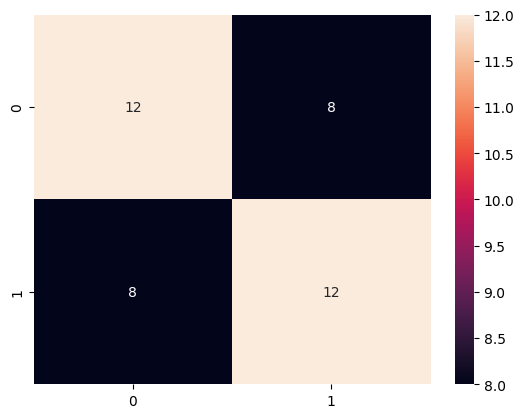

In [15]:
sns.heatmap(metrics.confusion_matrix(X_test.labels, X_pred) ,annot=True)
print(metrics.classification_report(X_test.labels, X_pred ))